<a href="https://colab.research.google.com/github/AnastasiaDv491/AA-course-assignment2/blob/main/AA_assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive') # mount google drive; use only if you have to access local files

Mounted at /content/gdrive


In [ ]:
# force remove a folder sample_data
!rm -rf sample_data

In [ ]:
pip install progress progressbar2 alive-progress tqdm

In [ ]:
# Import libraries
!pip install progress
import os
import random
from time import sleep
from progress.bar import Bar

import shutil  # For managing files and directories in a cross-platform manner
import keras  # For building deep learning models
import numpy as np  # For numerical operations on arrays
import glob  # For finding file paths
from tqdm import tqdm  # For progress bars

# Data preprocessing
from keras.preprocessing.image import ImageDataGenerator  # For image data augmentation

# Data visualization
import seaborn as sns  # For statistical visualizations
import plotly.graph_objs as go  # For interactive visualizations
import matplotlib.pyplot as plt  # For creating static plots

# Model architecture
from keras import Sequential  # For building sequential models
from keras.models import load_model  # For loading pre-trained models
from keras.layers import Dense, GlobalAvgPool2D  # For defining model layers

# Training callbacks
from keras.callbacks import ModelCheckpoint, EarlyStopping  # For training callbacks

# Pre-trained models
from tensorflow.keras.applications import InceptionV3, Xception, ResNet152V2, EfficientNetB7  # For using pre-trained models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# AA project 2


In [ ]:
!wget "http://seppe.net/aa/assignment2/images.zip" # load the data; takes a while

!unzip images.zip # unzip images file


In [ ]:
# get a random sample of images for the model; of 20000
# resources to include in the report: random sample the data
# https://stackoverflow.com/questions/59068321/placing-randomly-selected-images-into-new-folder
to_be_moved = random.sample(glob.glob("./images/*.jpg"), 10000)

for f in enumerate(to_be_moved, 1):
    dest = "./images_sample"
    if not os.path.exists(dest):
        os.makedirs(dest)
    shutil.copy(f[1], dest)

!rm images.zip # remove the zip file
!rm -rf images # remove images folder

In [ ]:
# check whether the image set contains any corrupt images and remove them
import PIL
from pathlib import Path
from PIL import UnidentifiedImageError

path = Path("./images_sample").rglob("*.jpg")
for img_p in path:
    try:
        img = PIL.Image.open(img_p)
    except PIL.UnidentifiedImageError:
      os.remove(img_p)
      print(img_p)

images_sample/4215425.jpg


In [ ]:
# Option1: getting json data; upload your local json file to continue
# this takes some time
import json
from google.colab import files
uploaded = files.upload()


In [ ]:
# Option2: load from the link
!gdown 11QCZxr4rXNk6kzJk4X4P_H8PnyarG7fJ

Downloading...
From: https://drive.google.com/uc?id=11QCZxr4rXNk6kzJk4X4P_H8PnyarG7fJ
To: /content/dataset.json
100% 108M/108M [00:00<00:00, 143MB/s] 


In [ ]:
# Loading json file and reading it
import json
json_file = open('dataset.json')
json_data = json.load(json_file)

In [ ]:
non_price_category_data = []

# Remove all restaurant data where there is no price_category. 
# Restaurant with no price category are stored in non_price_category_data array
# [:] makes shallow copy from the data so that we can remove the data from the original array
for restaurant in json_data[:]:
  if restaurant['price_category'] == None:
    non_price_category_data.append(restaurant)
    json_data.remove(restaurant)

In [ ]:
unique_label_slugs = []

# Get the unique slugs for price_category from the selected JSON data
for restaurant in json_data:
  if restaurant['price_category']['slug'] not in unique_label_slugs:
    unique_label_slugs.append(restaurant['price_category']['slug'])

unique_label_slugs

['mid-range', 'premium', 'luxury', 'affordable']

In [ ]:
debug_flag = False

import shutil 
import os

# creating sub-folders per label
for slug in unique_label_slugs:
  path = os.path.join('data',slug)
  if not os.path.exists(path):
    os.makedirs(path)

path = ""

for restaurant in json_data:
  for image in restaurant["more_details"]["full_images"]:
    if debug_flag:
      print(image["image_id"])
    basepath = os.path.join('data',restaurant["price_category"]["slug"])
    filename = image["image_id"]+".jpg"
    dest_path = os.path.join(basepath,filename)
    if os.path.isfile(dest_path):
      if debug_flag:
        print("File exists")
    else:
      source_path = os.path.join("images_sample",filename)
      if os.path.isfile(source_path):
        shutil.copyfile(source_path, dest_path)
      else:
        if debug_flag:
          print("File doesn't exist in base data")
  

In [ ]:
shutil.rmtree("data/.ipynb_checkpoints") # removes the hidden directory that messes with classes later on
os.listdir("data")


FileNotFoundError: ignored

In [ ]:
path = './data'

class_sizes = []
for name in unique_label_slugs:
    class_size = len(os.listdir(path+ "/" + name))
    class_sizes.append(class_size)
    
# Print the class distribution
print("Class Distribution:\n", class_sizes)

Class Distribution:
 [4164, 3145, 1881, 698]


In [ ]:
class_name_size = dict(zip(unique_label_slugs, class_sizes))
class_name_size

{'mid-range': 4164, 'premium': 3145, 'luxury': 1881, 'affordable': 698}

In [ ]:
pip install split-folders


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# splitting into train/valid/test
# https://medium.com/nerd-for-tech/easily-split-your-directory-into-train-validation-and-testing-format-f1359f34dd93
# https://pypi.org/project/split-folders/

import splitfolders
splitfolders.ratio("data", # The location of dataset
                   output="split_data", # The output location
                   seed=42, # The number of seed
                   ratio=(.7, .2, .1), # The ratio of splited dataset
                   group_prefix=None, # If your dataset contains more than one file like ".jpg", ".pdf", etc
                   move=False # If you choose to move, turn this into True
                   )

Copying files: 9888 files [00:06, 1460.70 files/s]


In [ ]:
# Data preprocessing
train_data_generator = ImageDataGenerator(
    rescale = 1./255,
    horizontal_flip = True,
    vertical_flip = True,
    rotation_range = 20,
    validation_split=0.2
)
# work in progress
test_data_generator = ImageDataGenerator(
    rescale = 1./255,
)

In [ ]:
# Most of the examples you will see online use only training and validation splits. they then use validation to track improvement in the model in each epoch.
# Finally, they also call model.evaluate on validation data which leads to overfitting. So to avoid this, here we are using three splits
random.seed(10567)

path = './data'
train_data = train_data_generator.flow_from_directory(
    './split_data/train',
    target_size =(256,256),
    class_mode = 'int',
    batch_size = 32,
    shuffle = True,
    subset = 'training',
    seed = 10567
)

valid_data = train_data_generator.flow_from_directory(
    './split_data/val', 
    target_size=(256,256), 
    class_mode='int', 
    batch_size=32, 
    shuffle=True, 
    subset='validation',
    seed = 10567)

# data generator for test_data: work in progress
test_data = test_data_generator.flow_from_directory(
    './split_data/test',
    batch_size=32, 
    shuffle=False,
    target_size=(256,256), 
    class_mode='int', 
    seed = 10567)

Found 5537 images belonging to 4 classes.
Found 393 images belonging to 4 classes.
Found 993 images belonging to 4 classes.


(32, 256, 256, 3)


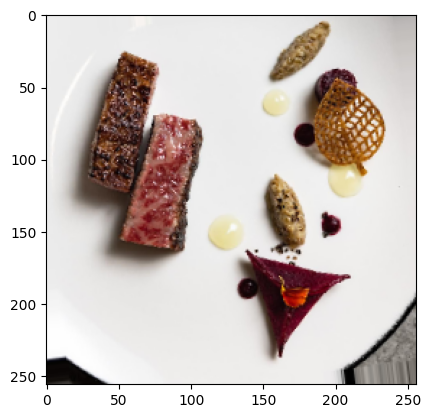

(32, 256, 256, 3)


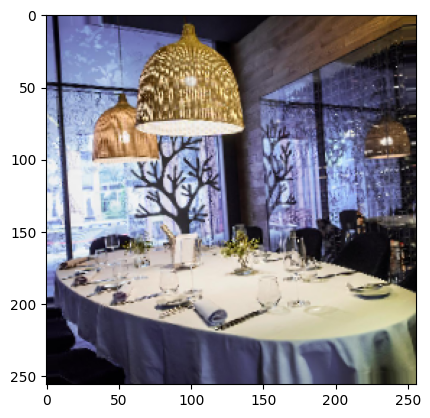

(32, 256, 256, 3)


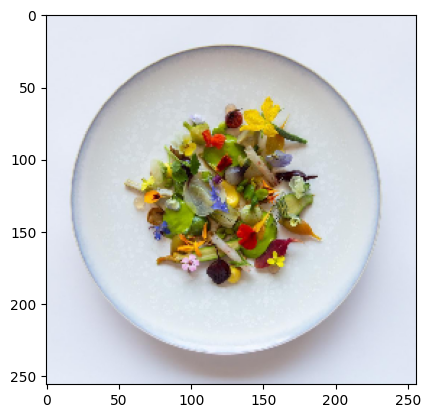

(32, 256, 256, 3)


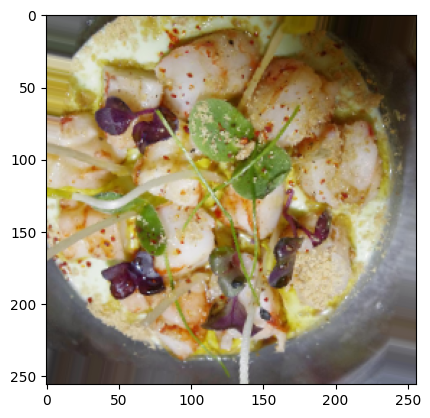

(32, 256, 256, 3)


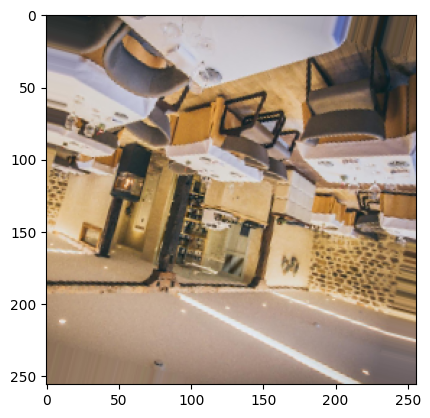

In [ ]:
import matplotlib.pyplot as plt
# https://stackoverflow.com/questions/63355107/keras-imagedatagenerator-result-display-flow
for _ in range(5):
    img, label = train_data.next()
    print(img.shape)   #  (32,256,256,3)
    plt.imshow(img[0])
    plt.show()

In [ ]:
#These models have been tried before coming to the final model
#Libraries that need to be imported
import keras
from keras import Sequential
from keras.layers import Dropout, BatchNormalization, Normalization, GlobalAveragePooling2D, Dense
from keras.models import load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import EfficientNetB7, InceptionV3, Xception, VGG16

#1. Baseline model from Anastasia
  name0 = "ResNet152V2"
  base_model0 = ResNet152V2(include_top=False, input_shape=(256,256,3), weights='imagenet') # freezing
  base_model0.trainable = False

  resnet = Sequential([
    Normalization( axis=None), # ! make sure to set this to none because otherwise the resulting model has a weird input shape that prevents the model from loading
    #https://github.com/keras-team/keras/issues/15348
    base_model0,
    GlobalAveragePooling2D(),
    Dense(256, activation = "relu"),
    Dropout(0.2),
    Dense(10, activation = "softmax")
  ], name = name0)

  resnet.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
  )

  cbs = [
    EarlyStopping(patience=3, restore_best_weights=True),
    ModelCheckpoint(name0 + ".h5", save_best_only=True)
  ]

  model0 = resnet.fit(
    train_data, validation_data=valid_data,
    epochs=1, callbacks=cbs
  )

#2. Resnet model
  name1 = "ResNet152V2"
  base_model1 = ResNet152V2(include_top=False, input_shape=(256,256,3), weights='imagenet') # freezing
  base_model1.trainable = False

  resnet = Sequential([
    Normalization(),
    base_model1,
    GlobalAveragePooling2D(),
    Dense(256, activation = "leaky_relu"),
    BatchNormalization(),
    Dropout(0.2),
    Dense(10, activation = "leaky_relu"),
    BatchNormalization(),
    Dense(4, activation='softmax')
  ], name = name1)

  optimizer1=keras.optimizers.Adam(learning_rate=0.01)
  resnet.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=optimizer1,
    metrics=['accuracy']
  )

  cbs = [
    EarlyStopping(patience=3, restore_best_weights=True),
    ModelCheckpoint(name1 + ".h5", save_best_only=True)
  ]

  model1 = resnet.fit(
    train_data, validation_data=valid_data,
    epochs=5, callbacks=cbs, batch_size=32
  )

#3. Efficientnet model
  name2="EfficientNetB7"
  base_model2 = EfficientNetB7(include_top=False, input_shape=(256,256,3), weights='imagenet') # freezing
  base_model2.trainable = False

  efficientnet = Sequential([
    Normalization(),
    base_model2,
    GlobalAveragePooling2D(),
    Dense(256, activation = "leaky_relu"),
    BatchNormalization(),
    Dropout(0.2),
    Dense(10, activation = "leaky_relu"),
    BatchNormalization(),
    Dense(4, activation='softmax')
  ], name = name2)

  optimizer2=keras.optimizers.Adam(learning_rate=0.01)
  efficientnet.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=optimizer2,
    metrics=['accuracy']
  )

  cbs = [
    EarlyStopping(patience=3, restore_best_weights=True),
    ModelCheckpoint(name2 + ".h5", save_best_only=True)
  ]

  model2 = efficientnet.fit(
    train_data, validation_data=valid_data,
    epochs=5, callbacks=cbs, batch_size=32
  )

#4. Inception model
name3="InceptionV3"
base_model3 = InceptionV3(include_top=False, input_shape=(256,256,3), weights='imagenet') # freezing
base_model3.trainable = False

inception = Sequential([
    Normalization(),
    base_model3,
    GlobalAveragePooling2D(),
    Dense(256, activation = "leaky_relu"),
    BatchNormalization(),
    Dropout(0.2),
    Dense(10, activation = "leaky_relu"),
    BatchNormalization(),
    Dense(4, activation='softmax')
], name = name3)

optimizer3=keras.optimizers.Adam(learning_rate=0.01)
inception.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=optimizer3,
    metrics=['accuracy']
)

cbs = [
    EarlyStopping(patience=3, restore_best_weights=True),
    ModelCheckpoint(name3 + ".h5", save_best_only=True)
]

model3 = inception.fit(
    train_data, validation_data=valid_data,
    epochs=5, callbacks=cbs, batch_size=32
)

#5. Xception
name4="Xception"
base_model4 = Xception(include_top=False, input_shape=(256,256,3), weights='imagenet') # freezing
base_model4.trainable = False

xception = Sequential([
    Normalization(),
    base_model4,
    GlobalAveragePooling2D(),
    Dense(256, activation = "leaky_relu"),
    BatchNormalization(),
    Dropout(0.2),
    Dense(10, activation = "leaky_relu"),
    BatchNormalization(),
    Dense(4, activation='softmax')
], name = name4)

optimizer4=keras.optimizers.Adam(learning_rate=0.01)
xception.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=optimizer4,
    metrics=['accuracy']
)

cbs = [
    EarlyStopping(patience=3, restore_best_weights=True),
    ModelCheckpoint(name4 + ".h5", save_best_only=True)
]

model4 = xception.fit(
    train_data, validation_data=valid_data,
    epochs=5, callbacks=cbs, batch_size=32
)

#6. VGG16 model
name5="VGG16"
base_model5 = VGG16(include_top=False, input_shape=(256,256,3), weights='imagenet') # freezing
base_model5.trainable = False

VGG16 = Sequential([
    Normalization(),
    base_model5,
    GlobalAveragePooling2D(),
    Dense(256, activation = "leaky_relu"),
    BatchNormalization(),
    Dropout(0.2),
    Dense(10, activation = "leaky_relu"),
    BatchNormalization(),
    Dense(4, activation='softmax')
], name = name5)

optimizer5=keras.optimizers.Adam(learning_rate=0.01)
VGG16.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=optimizer5,
    metrics=['accuracy']
)

cbs = [
    EarlyStopping(patience=3, restore_best_weights=True),
    ModelCheckpoint(name5 + ".h5", save_best_only=True)
]

model5 = VGG16.fit(
    train_data, validation_data=valid_data,
    epochs=5, callbacks=cbs, batch_size=32
)

#according to table, resnet model performs the best. We can update this model further.
#7. first update resnet model: one Dense layer extra
name6 = "ResNet152V2"
base_model6 = ResNet152V2(include_top=False, input_shape=(256,256,3), weights='imagenet') # freezing
base_model6.trainable = False

resnet = Sequential([
    Normalization(),
    base_model6,
    GlobalAveragePooling2D(),
    Dense(10, activation = "leaky_relu"),
    BatchNormalization(),
    Dropout(0.2),
    Dense(10, activation = "leaky_relu"),
    BatchNormalization(),
    Dense(10, activation = "leaky_relu"),
    BatchNormalization(),
    Dense(4, activation='softmax')
], name = name6)

optimizer6=keras.optimizers.Adam(learning_rate=0.01)
resnet.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=optimizer6,
    metrics=['accuracy']
)

cbs = [
    EarlyStopping(patience=3, restore_best_weights=True),
    ModelCheckpoint(name6 + ".h5", save_best_only=True)
]

model6 = resnet.fit(
    train_data, validation_data=valid_data,
    epochs=5, callbacks=cbs, batch_size=32
)

#8. New update: 2 Dense layers extra
name7 = "ResNet152V2"
base_model7 = ResNet152V2(include_top=False, input_shape=(256,256,3), weights='imagenet') # freezing
base_model7.trainable = False

resnet = Sequential([
    Normalization(),
    base_model7,
    GlobalAveragePooling2D(),
    Dense(10, activation = "leaky_relu"),
    BatchNormalization(),
    Dropout(0.2),
    Dense(10, activation = "leaky_relu"),
    BatchNormalization(),
    Dense(10, activation = "leaky_relu"),
    BatchNormalization(),
    Dropout(0.2),
    Dense(10, activation = "leaky_relu"),
    BatchNormalization(),
    Dense(4, activation='softmax')
], name = name)

optimizer7=keras.optimizers.Adam(learning_rate=0.01)
resnet.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=optimizer7,
    metrics=['accuracy']
)

cbs = [
    EarlyStopping(patience=3, restore_best_weights=True),
    ModelCheckpoint(name7 + ".h5", save_best_only=True)
]

model7 = resnet.fit(
    train_data, validation_data=valid_data,
    epochs=5, callbacks=cbs, batch_size=32
)

#9. one Dense layer less than original Resnetmodel
name8 = "ResNet152V2"
base_model8 = ResNet152V2(include_top=False, input_shape=(256,256,3), weights='imagenet') # freezing
base_model8.trainable = False

resnet = Sequential([
    Normalization(),
    base_model8,
    GlobalAveragePooling2D(),
    Dense(4, activation='softmax')
], name = name8)

optimizer8=keras.optimizers.Adam(learning_rate=0.01)
resnet.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=optimizer8,
    metrics=['accuracy']
)

cbs = [
    EarlyStopping(patience=3, restore_best_weights=True),
    ModelCheckpoint(name8 + ".h5", save_best_only=True)
]

model8 = resnet.fit(
    train_data, validation_data=valid_data,
    epochs=5, callbacks=cbs, batch_size=32
)


In [ ]:
#Best model: Resnet model with two Dense layers, global average pooling, normalization layer, batch normalization layer and a dropout of 0.2
name9 = "ResNet152V2"
base_model9 = ResNet152V2(include_top=False, input_shape=(256,256,3), weights='imagenet') # freezing
base_model9.trainable = False

resnet = Sequential([
    Normalization(),
    base_model9,
    GlobalAveragePooling2D(),
    Dense(10, activation = "leaky_relu"),
    BatchNormalization(),
    Dropout(0.2),
    Dense(4, activation='softmax')
], name = name9)

optimizer9=keras.optimizers.Adam(learning_rate=0.01)
resnet.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=optimizer9,
    metrics=['accuracy']
)

cbs = [
    EarlyStopping(patience=3, restore_best_weights=True),
    ModelCheckpoint(name9 + ".h5", save_best_only=True)
]

model9 = resnet.fit(
    train_data, validation_data=valid_data,
    epochs=5, callbacks=cbs, batch_size=32
)

234545216/234545216 [==============================] - 11s 0us/step
Epoch 1/5
174/174 [==============================] - 243s 1s/step - loss: 1.2678 - accuracy: 0.4140 - val_loss: 1.2193 - val_accuracy: 0.4492
Epoch 2/5
174/174 [==============================] - 232s 1s/step - loss: 1.1727 - accuracy: 0.4462 - val_loss: 1.2331 - val_accuracy: 0.4289
Epoch 3/5
174/174 [==============================] - 223s 1s/step - loss: 1.1594 - accuracy: 0.4554 - val_loss: 1.1906 - val_accuracy: 0.4264
Epoch 4/5
174/174 [==============================] - 224s 1s/step - loss: 1.1469 - accuracy: 0.4605 - val_loss: 1.1858 - val_accuracy: 0.4340
Epoch 5/5
174/174 [==============================] - 222s 1s/step - loss: 1.1433 - accuracy: 0.4628 - val_loss: 1.2198 - val_accuracy: 0.4442


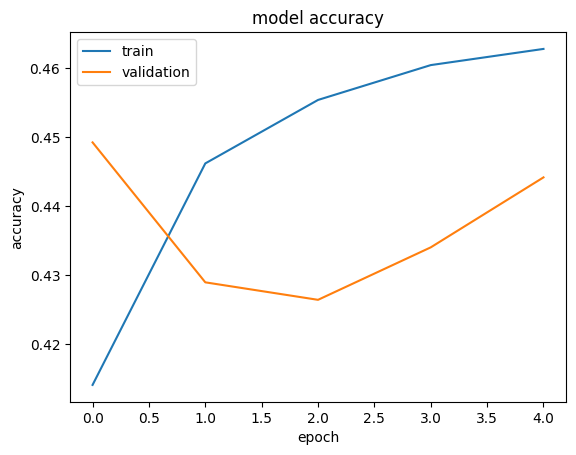

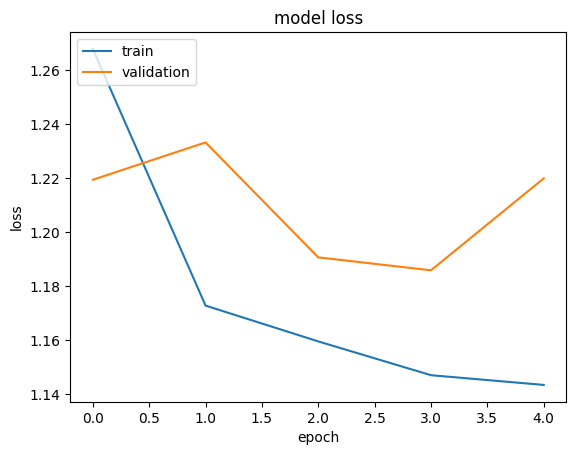

In [ ]:
#Plot losses and accuracies
#accuracy
plt.plot(model9.history['accuracy'])
plt.plot(model9.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(model9.history['loss'])
plt.plot(model9.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

#it seems like adding some more epochs could imporve efficiency.

In [ ]:
#FINAL MODEL
#Rerun best model with 10 epochs
name10 = "ResNet152V2bestmodel"
base_model10 = ResNet152V2(include_top=False, input_shape=(256,256,3), weights='imagenet') # freezing
base_model10.trainable = False

resnet = Sequential([
    Normalization(axis=None),
    base_model10,
    GlobalAveragePooling2D(),
    Dense(10, activation = "leaky_relu"),
    BatchNormalization(),
    Dropout(0.2),
    Dense(4, activation='softmax')
], name = name10)

optimizer10=keras.optimizers.Adam(learning_rate=0.01)
resnet.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=optimizer10,
    metrics=['accuracy']
)

cbs = [
    EarlyStopping(patience=3, restore_best_weights=True),
    ModelCheckpoint(name10 + ".h5", save_best_only=True)
]

model10 = resnet.fit(
    train_data, validation_data=valid_data,
    epochs=10, callbacks=cbs, batch_size=32
)

Epoch 1/10
174/174 [==============================] - 281s 2s/step - loss: 1.2485 - accuracy: 0.4219 - val_loss: 1.2024 - val_accuracy: 0.4402
Epoch 2/10
174/174 [==============================] - 260s 1s/step - loss: 1.1730 - accuracy: 0.4578 - val_loss: 1.2098 - val_accuracy: 0.4555
Epoch 3/10
174/174 [==============================] - 258s 1s/step - loss: 1.1519 - accuracy: 0.4645 - val_loss: 1.1936 - val_accuracy: 0.4733
Epoch 4/10
174/174 [==============================] - 259s 1s/step - loss: 1.1399 - accuracy: 0.4723 - val_loss: 1.2067 - val_accuracy: 0.4860
Epoch 5/10
174/174 [==============================] - 264s 2s/step - loss: 1.1395 - accuracy: 0.4710 - val_loss: 1.2578 - val_accuracy: 0.4631
Epoch 6/10
174/174 [==============================] - 266s 2s/step - loss: 1.1251 - accuracy: 0.4795 - val_loss: 1.2540 - val_accuracy: 0.4478


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

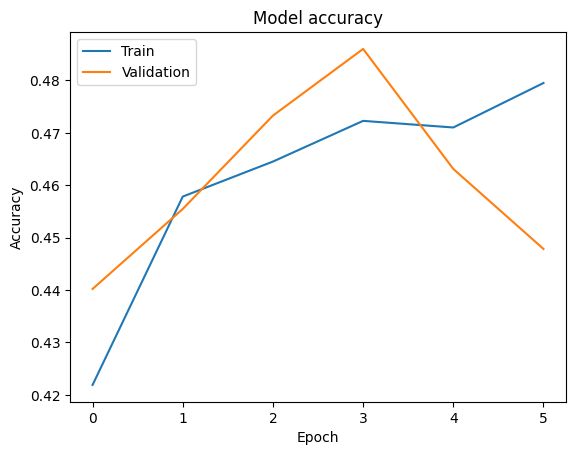

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

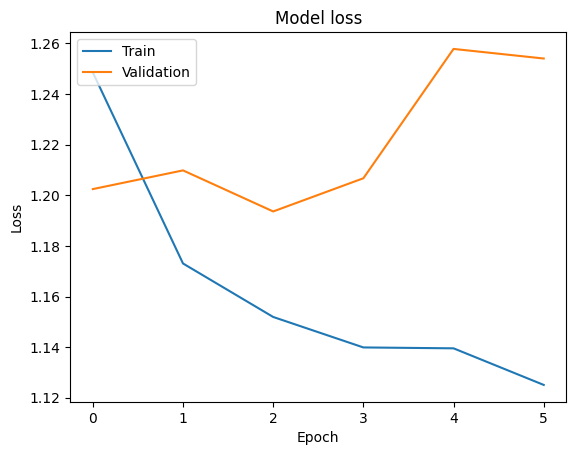

In [ ]:
#Plot losses and accuracies
#accuracy
from google.colab import files
plt.plot(model10.history['accuracy'])
plt.plot(model10.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('accuracy.png')
files.download('accuracy.png')
plt.show()

# "Loss"
plt.plot(model10.history['loss'])
plt.plot(model10.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('loss.png')
files.download('loss.png')
plt.show()


#From the plot, it emerges that 6 epochs results in the best validation accuracy with also a similar train accuracy. However, this is still
#beneath 50%, thus the model is not very good yet. 
#The loss has a similar analysis

In [ ]:
#Load model summary
model_file_path = "ResNet152V2bestmodel.h5"
loaded_model = load_model(model_file_path)
loaded_model.summary()

loaded_model.evaluate(valid_data)

Model: "ResNet152V2bestmodel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, None, None, None)  3        
 n)                                                              
                                                                 
 resnet152v2 (Functional)    (None, 8, 8, 2048)        58331648  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 10)                20490     
                                                                 
 batch_normalization (BatchN  (None, 10)               40        
 ormalization)                                                   
                                              

[1.2298438549041748, 0.44020354747772217]

In [ ]:
prediction_output = loaded_model.predict(test_data)

predicted_class = np.argmax(prediction_output,axis=1)


In [ ]:
predicted_class

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 3, 1, 2, 2, 3, 1, 2, 2, 1, 2, 1,
       1, 2, 2, 2, 2, 3, 2, 1, 2, 1, 2, 2, 1, 3, 2, 1, 2, 2, 2, 2, 1, 1,
       2, 2, 2, 2, 2, 3, 2, 1, 1, 2, 2, 1, 2, 1, 1, 2, 2, 2, 1, 2, 1, 1,
       1, 2, 0, 2, 3, 1, 2, 2, 2, 3, 2, 1, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 1, 2, 2, 2, 2, 1, 2, 2, 3, 2, 2, 1, 1, 2, 2, 2, 1, 2, 1, 2, 1,
       2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 1, 2, 2, 3, 1, 3,
       1, 1, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 3, 2, 2, 3, 1,
       2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 3, 1, 2, 1, 3, 2, 1,
       1, 1, 2, 1, 1, 2, 2, 1, 2, 3, 2, 1, 2, 1, 1, 2, 1, 2, 2, 2, 2, 2,
       2, 3, 2, 2, 1, 3, 2, 2, 2, 3, 2, 3, 2, 3, 2, 2, 2, 2, 1, 2, 2, 3,
       2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 1, 1, 2, 3, 3, 1, 1, 2, 2, 1, 1, 3,
       2, 1, 2, 0, 2, 3, 3, 3, 2, 1, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 1,
       2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 3, 2, 1,
       2, 1, 2, 2, 1, 2, 2, 2, 2, 3, 2, 3, 2, 3, 1,